# Displacement analysis

Copyright 2021 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal**: Learn how to plot and analyse displacement from digital image correlation data (DICe output).

In [1]:
# Import neccesary libraries
import os
import numpy as np
import pandas as pd
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

## Step 1: Load the dataset

> For details on the process of reading DICe data and creating efficient Python structures see the following notebook [Loading DICe data](https://nbviewer.jupyter.org/github/marcoalopez/Jupyter4DICe/blob/f277d346a009570cf645123dc8fa93f7a0eea4f4/notebooks/LoadingDICe_data.ipynb)

In [3]:
path = 'dataset/'

# loop to extract the data
count = 1
print('Stacking data...')

for filename in os.listdir(path):
    if filename.startswith('DICe') and filename.endswith('.txt'):
        
        # load the corresponding txt file
        df = pd.read_csv(path + filename, delimiter=',')
        
        # separate the different parameters of interest and reorganize them as a matrix
        disp_X = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_X')
        disp_Y = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='DISPLACEMENT_Y')
        rot_Z = df.pivot(index='COORDINATE_Y', columns='COORDINATE_X', values='ROTATION_Z')

        
        # generate the numpy arrays
        if count == 1:
            dispX_stack = np.array(disp_X)
            dispY_stack = np.array(disp_Y)
            rotZ_stack = np.array(rot_Z)
            print(f'first processing file: {filename}')
            print('it might take a while...') 
        
        else:
            dispX_stack = np.dstack((dispX_stack, np.array(disp_X)))
            dispY_stack = np.dstack((dispY_stack, np.array(disp_Y)))
            rotZ_stack = np.dstack((rotZ_stack, np.array(rot_Z)))
        count += 1
        print('#', end = '')

print('')
print(f'last processing file: {filename}')
print('Done!')
print(f'Shape of arrays: {dispX_stack.shape}')

data = SimpleNamespace(dispX=dispX_stack,
                       dispY=dispY_stack,
                       rotZ=rotZ_stack)

# remove variables that are not going to be used (to release RAM memory)
del df, count, filename, disp_X, disp_Y, rot_Z, dispX_stack, dispY_stack, rotZ_stack

Stacking data...
first processing file: DICe_solution_000.txt
it might take a while...
##########
last processing file: DICe_solution_074.txt
Done!
Shape of arrays: (377, 189, 10)


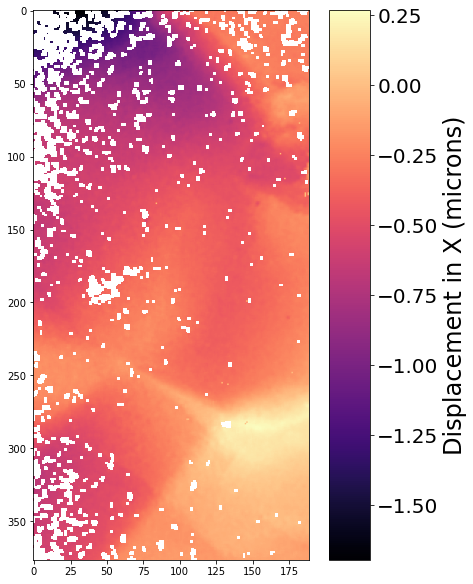

In [8]:
# initialize figure
fig1, ax = plt.subplots(constrained_layout=True)

# image (take time step 10 --> [:, :, 9])
im = ax.imshow(data.dispX[:, :, 9], cmap='magma')

# add a color bar
cbar = fig1.colorbar(im, ax=ax)
cbar.set_label('Displacement in X (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

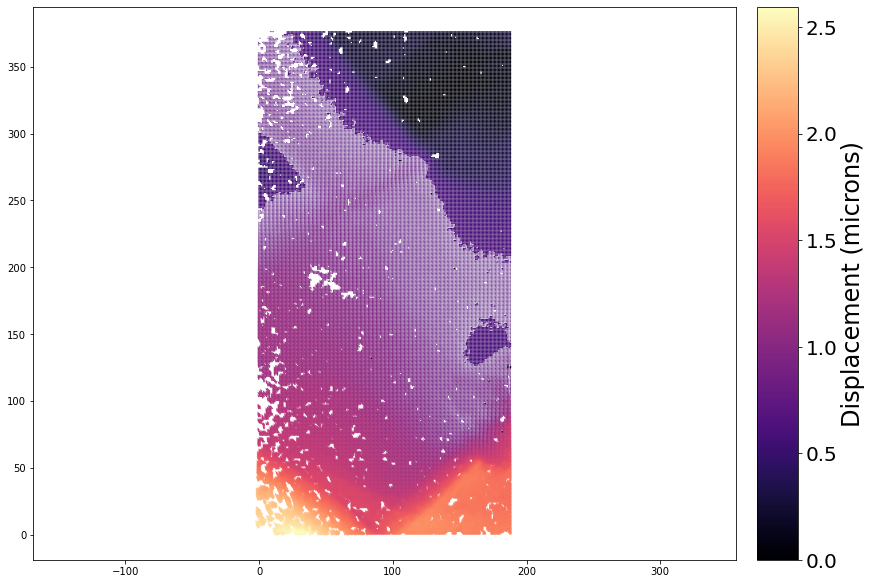

In [30]:
# make...
x, y = np.meshgrid(np.arange(189), np.arange(377))
#u, v = data.dispX[:, :, 9].flat, data.dispY[:, :, 9].flat
magnitude = np.hypot(data.dispX[:, :, 9], data.dispY[:, :, 9])

# initialize figure
fig2, ax = plt.subplots(constrained_layout=True)

# image (take time step 10 --> [:, :, 9])
im = ax.quiver(x, y, data.dispX[:, :, 9], data.dispY[:, :, 9], magnitude, scale_units='xy', scale=0.5, cmap='magma')
ax.axis('equal') # equal aspect ratio

# add a color bar
cbar = fig2.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

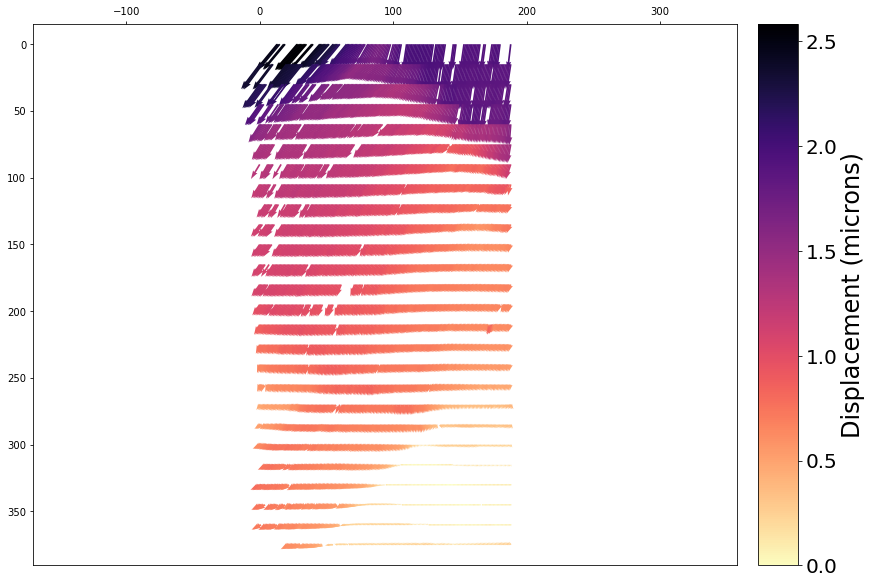

In [32]:
# make...
x, y = np.meshgrid(np.arange(189), np.arange(377))
u, v = data.dispX[:, :, 9], data.dispY[:, :, 9]
magnitude = np.hypot(data.dispX[:, :, 9], data.dispY[:, :, 9])

# initialize figure
fig2, ax = plt.subplots(constrained_layout=True)

ax.invert_yaxis()
ax.xaxis.tick_top()
v = v * -1  # invert y displacement

# image (take time step 10 --> [:, :, 9])
im = ax.quiver(x[::15], y[::15], u[::15], v[::15], magnitude[::15], scale_units='xy', scale=0.1, cmap='magma_r')
ax.axis('equal') # equal aspect ratio

# add a color bar
cbar = fig2.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

AttributeError: 'StreamplotSet' object has no attribute 'get_array'

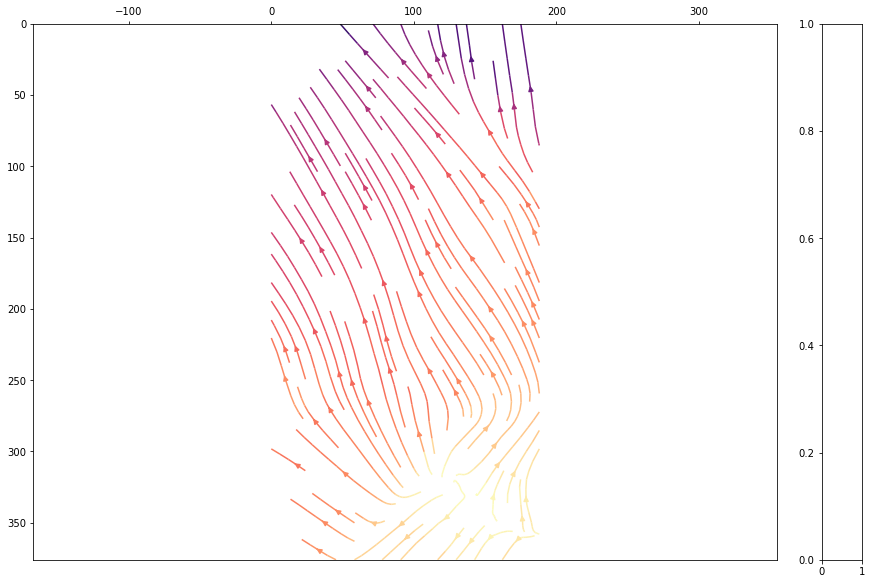

In [36]:
# initialize figure
fig3, ax = plt.subplots(constrained_layout=True)

ax.invert_yaxis()
ax.xaxis.tick_top()

# image (take time step 10 --> [:, :, 9])
im = ax.streamplot(x, y, u, v, color=magnitude, cmap='magma_r')
ax.axis('equal') # equal aspect ratio

# add a color bar
cbar = fig3.colorbar(im, ax=ax)
cbar.set_label('Displacement (microns)', fontsize=24)
cbar.ax.tick_params(labelsize=20)